<a href="https://colab.research.google.com/github/md-abdullah-al-mamun-mojumder/Elastic-optical-network/blob/main/FA_TA_RMSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

In [ ]:
# Step 1: Define Networks
def create_german_network():
    G = nx.Graph()
    edges = [
        (1, 2, 144), (1, 3, 278), (2, 4, 144), (2, 6, 120),
        (3, 5, 37), (3, 6, 208), (3, 9, 88), (4, 6, 157), (4, 8, 306),
        (5, 7, 36), (6, 8, 298), (6, 10, 258), (6, 11, 316), (7, 9, 41),
        (8, 10, 174), (9, 11, 182), (10, 12, 275), (10, 11, 353),
        (11, 12, 224), (11, 13, 85), (12, 14, 179), (12, 17, 189),
        (13, 15, 64), (14, 16, 143), (16, 17, 86), (17, 15, 74)
    ]
    G.add_weighted_edges_from(edges)
    return G

def create_usnet_network():
    G = nx.Graph()
    edges = [
        (1, 2, 800), (1, 3, 1000), (2, 3, 950), (2, 4, 1000),
        (3, 5, 1000), (3, 9, 1200), (3, 11, 1900), (4, 5, 1000),
        (4, 6, 2500), (4, 7, 800), (5, 6, 850), (5, 8, 1150), (5, 9, 1000),
        (6, 7, 800), (7, 8, 1200), (8, 23, 900), (9, 10, 1000), (9, 11, 1400),
         (9, 23, 1000), (10, 11, 900), (10, 13, 1000), (10, 22, 900),
        (11, 12, 1300), (11, 14, 2600), (12, 13, 600), (12, 15, 1300), (13, 16, 1000),
        (13, 17, 800), (13,19, 1000), (14, 15, 1200), (15, 16, 700), (16, 17, 300),
        (17, 18, 600), (17, 19, 850), (18, 19, 1000), (19, 21, 800), (19, 22, 1100),
        (20, 21, 900), (21, 24, 1200), (22, 23, 950), (22, 24, 650), (23, 24, 850)
    ]
    G.add_weighted_edges_from(edges)
    return G

In [ ]:
# Step 2: Compute Betweenness Centrality
def compute_betweenness(G):
    return nx.edge_betweenness_centrality(G, normalized=True)

In [ ]:
# Step 3: Spectrum Initialization
def initialize_spectrum(G, cores=2, slots=320):
    spectrum = {}
    for edge in G.edges:
        link = tuple(sorted(edge))
        spectrum[link] = {core: [1] * slots for core in range(cores)}
    return spectrum

In [ ]:
# Step 4: Slot Allocation
def allocate_slots(spectrum, path, slots_required, cores):
    for core in range(cores):
        available = True
        for i in range(len(path) - 1):
            link = tuple(sorted((path[i], path[i + 1])))
            if link not in spectrum:
                raise KeyError(f"Edge {link} is missing from the spectrum dictionary.")
            free_slots = spectrum[link][core]
            if sum(free_slots[:slots_required]) < slots_required:
                available = False
                break
        if available:
            for i in range(len(path) - 1):
                link = tuple(sorted((path[i], path[i + 1])))
                for j in range(slots_required):
                    spectrum[link][core][j] = 0
            return True
    return False

In [ ]:
# Step 5: Simulation
def simulate(G, spectrum, requests, betweenness, cores=2, slots=320):
    blocked_requests = 0
    blocked_bandwidth = 0
    total_bandwidth = 0

    for req in requests:
        source, destination, bandwidth = req
        path = nx.shortest_path(G, source, destination, weight='weight')
        slots_required = math.ceil(bandwidth / (50 * 12.5))  # Example for M = 4
        success = allocate_slots(spectrum, path, slots_required, cores)
        if not success:
            blocked_requests += 1
            blocked_bandwidth += bandwidth
        total_bandwidth += bandwidth

    rbp = blocked_requests / len(requests)
    bbp = blocked_bandwidth / total_bandwidth
    return rbp, bbp

In [ ]:
# Step 6: Traffic Generation
def generate_requests(G, num_requests, traffic_load, min_bandwidth=50, max_bandwidth=250):
    requests = []
    nodes = list(G.nodes)
    for _ in range(num_requests):
        source, destination = np.random.choice(nodes, 2, replace=False)
        bandwidth = np.random.randint(min_bandwidth, max_bandwidth + 1)
        requests.append((source, destination, bandwidth))
    return requests

In [ ]:

# Step 7: Main Execution and Graph Plotting
german_network = create_german_network()
usnet_network = create_usnet_network()

german_betweenness = compute_betweenness(german_network)
usnet_betweenness = compute_betweenness(usnet_network)

traffic_loads = range(10, 70, 10)  # Traffic load in Erlangs
german_rbp_values, german_bbp_values = [], []
usnet_rbp_values, usnet_bbp_values = [], []

for load in traffic_loads:
    num_requests = load * 100  # Scale traffic load to requests
    german_requests = generate_requests(german_network, num_requests, load)
    usnet_requests = generate_requests(usnet_network, num_requests, load)

    german_spectrum = initialize_spectrum(german_network)
    usnet_spectrum = initialize_spectrum(usnet_network)

    german_rbp, german_bbp = simulate(german_network, german_spectrum, german_requests, german_betweenness)
    usnet_rbp, usnet_bbp = simulate(usnet_network, usnet_spectrum, usnet_requests, usnet_betweenness)

    german_rbp_values.append(german_rbp)
    german_bbp_values.append(german_bbp)
    usnet_rbp_values.append(usnet_rbp)
    usnet_bbp_values.append(usnet_bbp)

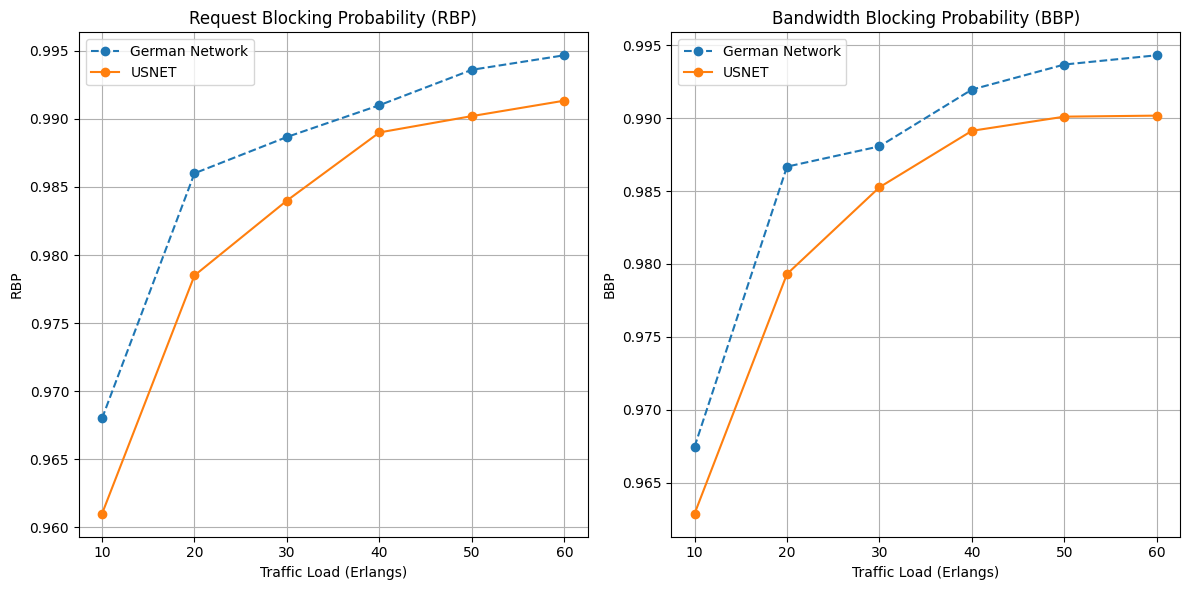

In [ ]:

# Plot Results
plt.figure(figsize=(12, 6))

# RBP Plot
plt.subplot(1, 2, 1)
plt.plot(traffic_loads, german_rbp_values, label='German Network', marker='o', linestyle='--')
plt.plot(traffic_loads, usnet_rbp_values, label='USNET', marker='o', linestyle='-')
plt.title('Request Blocking Probability (RBP)')
plt.xlabel('Traffic Load (Erlangs)')
plt.ylabel('RBP')
plt.legend()
plt.grid(True)

# BBP Plot
plt.subplot(1, 2, 2)
plt.plot(traffic_loads, german_bbp_values, label='German Network', marker='o', linestyle='--')
plt.plot(traffic_loads, usnet_bbp_values, label='USNET', marker='o', linestyle='-')
plt.title('Bandwidth Blocking Probability (BBP)')
plt.xlabel('Traffic Load (Erlangs)')
plt.ylabel('BBP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()